### Homework: 6
### Name: Daniel Jang
### GitHub: hjang8659
### USC ID: 6894-6426-04
### Due: Mar 29, 2024

In [1]:
import pandas as pd
import numpy as np
import math
import re
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
from xgboost import XGBClassifier

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split, StratifiedKFold, cross_validate, KFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, Ridge, LassoCV, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric, KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import pinv
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.utils import resample
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import _tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE

### 1
### (a)

In [2]:
train_path = '../data/aps_failure_training_set.csv'
test_path = '../data/aps_failure_test_set.csv'

train_data = pd.read_csv(train_path, skiprows=20)
test_data = pd.read_csv(test_path, skiprows=20)

train_data.replace('na', np.nan, inplace=True)
test_data.replace('na', np.nan, inplace=True)

x_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:, 0]

x_test = test_data.iloc[:,1:]
y_test = test_data['class']

train_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,NaN,0,NaN,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,NaN,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,NaN,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,NaN,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,NaN,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,NaN,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


### (b)
### i.
### Some of the common imputation besides deletion are mean, median, and mode imputation. Some advanced techniques are singular value decomposition (SVD), expectation-maximization (EM), KNN, and predictive imputation. For this problem, I will be using mean imputation with SimpleImputer library.

In [3]:
imputer = SimpleImputer(strategy='mean')

x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train))
x_test_imputed = pd.DataFrame(imputer.transform(x_test))

In [4]:
x_train_imputed.isnull()
if (x_train_imputed == False).any().any():
    print("No NaN found")

No NaN found


In [5]:
x_test_imputed.isnull()
if (x_test_imputed == False).any().any():
    print("No NaN found")

No NaN found


### ii.

In [6]:
m = x_train_imputed.mean()

s = x_train_imputed.std()

CV = s / m

print(CV)

0        2.450938
1        2.328400
2        2.169767
3      183.847620
4       23.190937
          ...    
165      4.962483
166      3.222010
167      5.626979
168     47.124953
169     40.553250
Length: 170, dtype: float64


### iii.

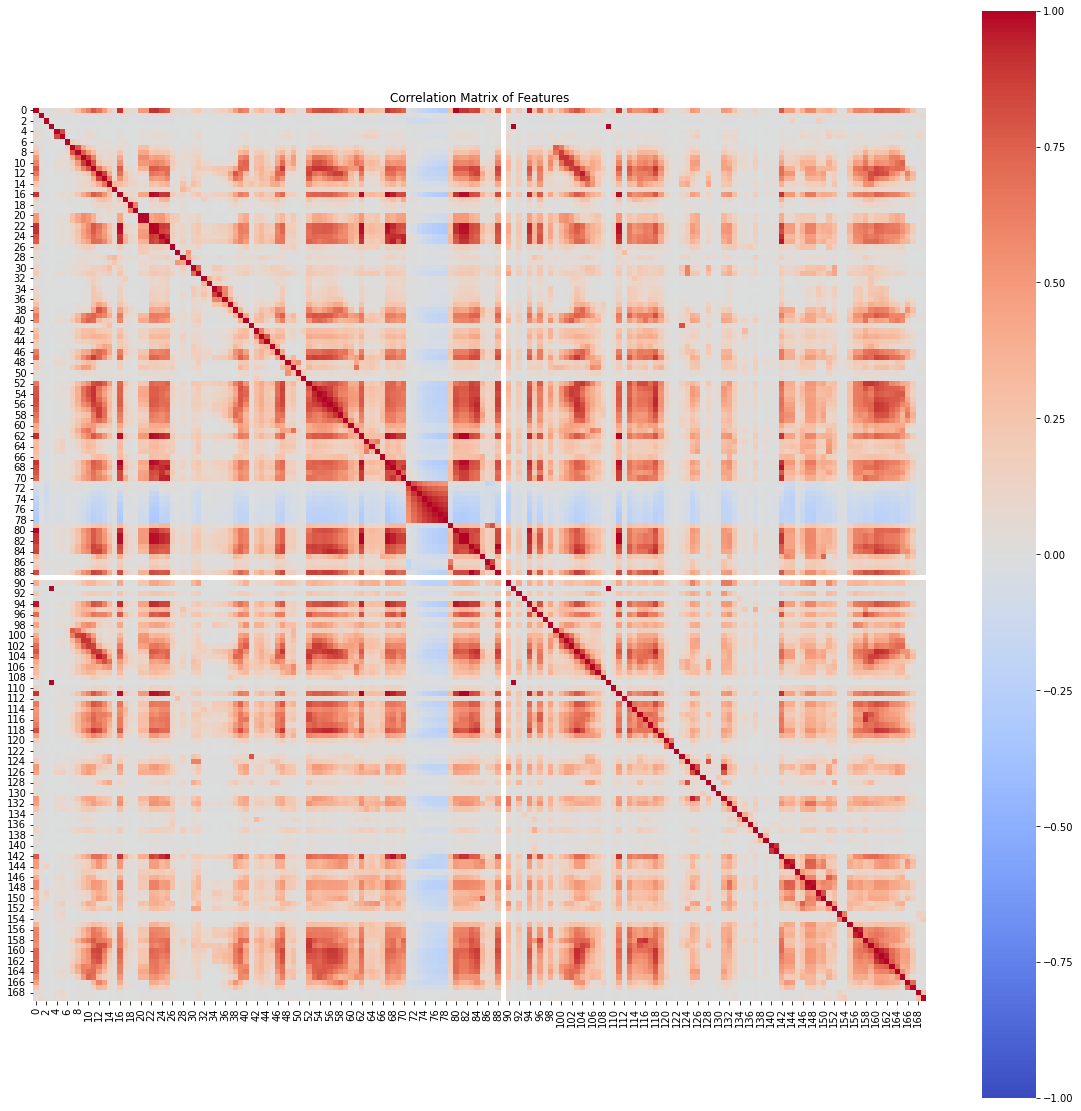

In [7]:
correlation = x_train_imputed.corr()

plt.figure(figsize=(20, 20))
ax = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show();

### Hard to visualize due to large volumne of features. Here is a subset of first 20 features. Note this may not be the best practice due to potentially missing correlations with other features.

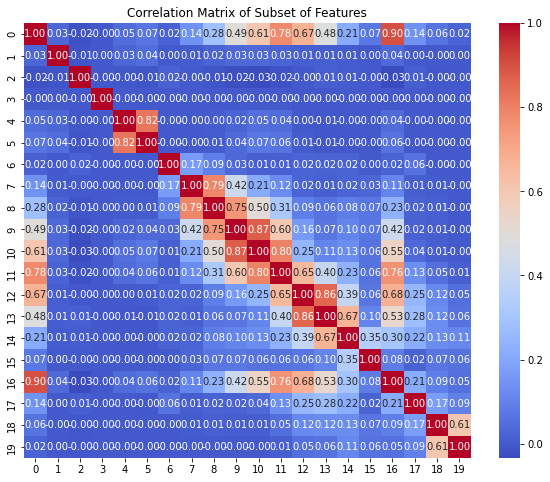

In [8]:
subset_features = x_train_imputed.iloc[:, :20]

subset_corr_matrix = subset_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Subset of Features')
plt.show();

### iv.

In [9]:
threshold = int(np.floor(np.sqrt(170)))

sorted_variation = CV.sort_values(ascending=False)

selected_features = sorted_variation.iloc[:threshold].index

train_features = x_train_imputed[selected_features]

train_features.head()

,122,91,109,3,136,138,6,27,41,51,19,29,93
0,0.0,2.000000,220.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,190221.810984,190515.566938,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000443
2,0.0,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,2.000000,2.000000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,202.000000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


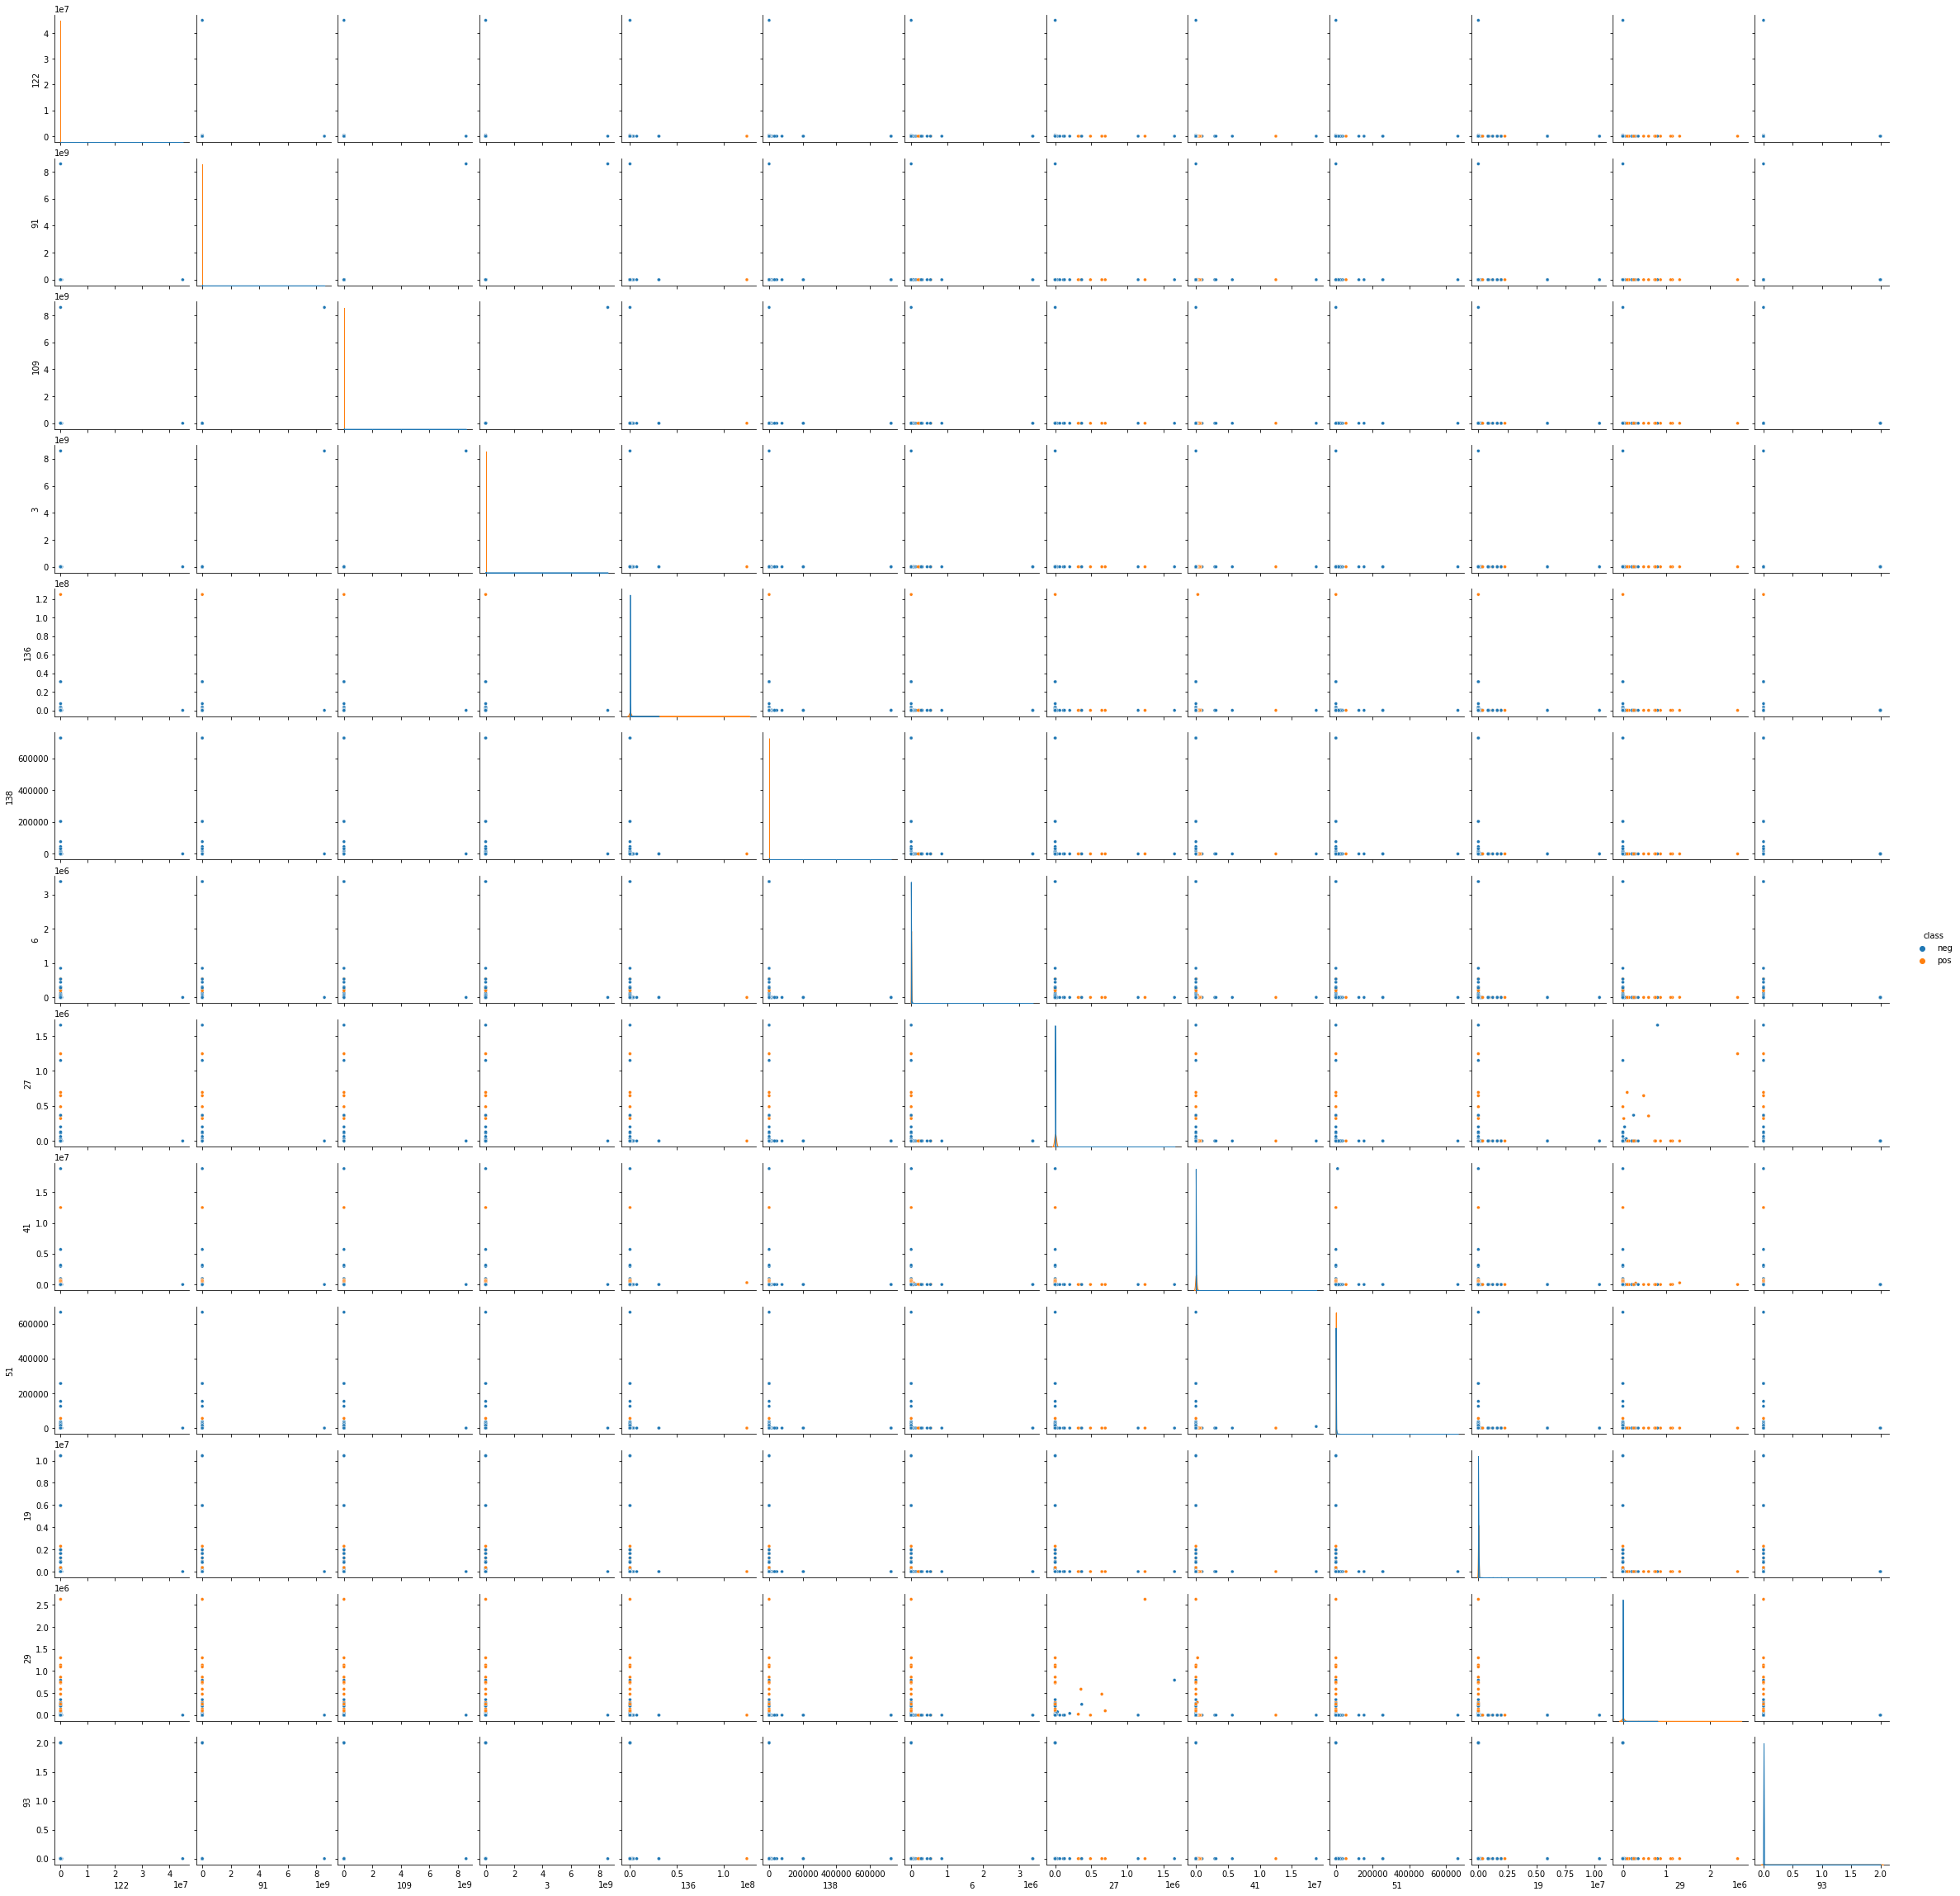

In [10]:
train_features_copy = train_features.copy()

train_features_copy['class'] = y_train

sns.pairplot(train_features_copy, plot_kws={'s': 15}, hue='class');

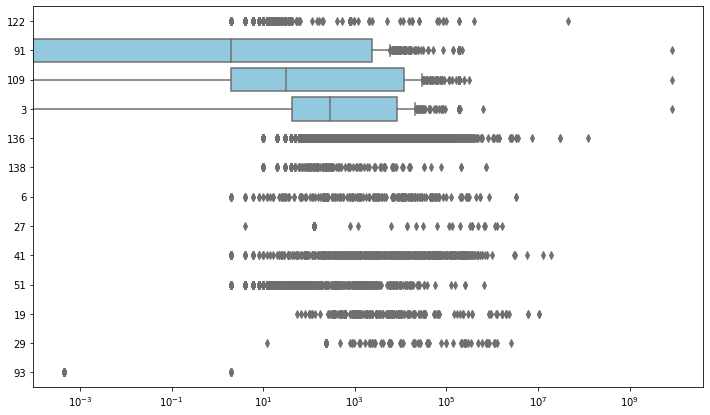

In [11]:
high_CV_feats = sorted_variation.iloc[:threshold]

fig, axes = plt.subplots(figsize=(12, 7))
box = sns.boxplot(data=x_train_imputed[high_CV_feats.index.tolist()], orient='h', ax=axes, color='skyblue')
box.set(xscale="log")
plt.show();

### It's hard to assess the significance of features solely through scatter plots, especially when using mean imputation, as outliers can heavily influence the results.
### v.

In [12]:
print('Train Data')
print(y_train.value_counts())
print('Test Data')
print(y_test.value_counts())

Train Data
neg    59000
pos     1000
Name: class, dtype: int64
Test Data
neg    15625
pos      375
Name: class, dtype: int64


### Yes data set is imbalanced.
### (c)

In [13]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True, random_state=42)
rf_classifier.fit(x_train_imputed, y_train)

y_train_pred = rf_classifier.predict(x_train_imputed)
y_test_pred = rf_classifier.predict(x_test_imputed)

y_train_pred_proba = rf_classifier.predict_proba(x_train_imputed)[:, 1]
y_test_pred_proba = rf_classifier.predict_proba(x_test_imputed)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)

oob_error = 1 - rf_classifier.oob_score_

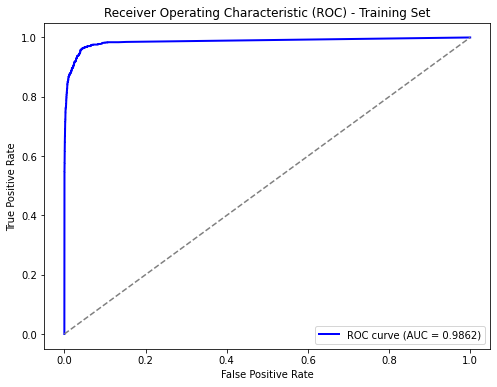

Confusion Matrix for Training Set:
[[58976    24]
 [  432   568]]
ROC AUC for Training Set: 0.9862412881355932
Misclassification for Training Set: 0.007600000000000051


In [14]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Set')
plt.legend(loc='lower right')
plt.show();


print("Confusion Matrix for Training Set:")
print(conf_matrix_train)
print("ROC AUC for Training Set:", roc_auc_train)
print("Misclassification for Training Set:", misclassification_train)

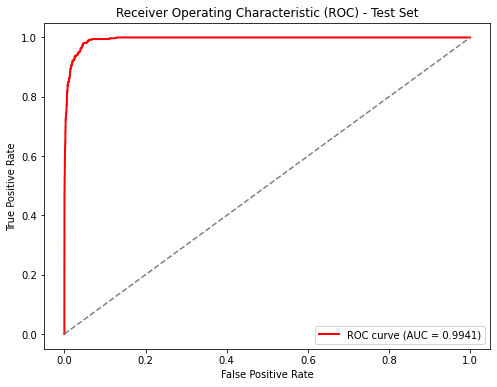

Confusion Matrix for Test Set:
[[15611    14]
 [  173   202]]
ROC AUC for Test Set: 0.9941385386666667
Misclassification for Test Set: 0.011687499999999962


In [15]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Set')
plt.legend(loc='lower right')
plt.show();

print("Confusion Matrix for Test Set:")
print(conf_matrix_test)
print("ROC AUC for Test Set:", roc_auc_test)
print("Misclassification for Test Set:", misclassification_test)

In [16]:
print("Out of Bag (OOB) Error Estimate:", oob_error)

Out of Bag (OOB) Error Estimate: 0.00928333333333331


### OOB is lower than test error.
### (d)

In [17]:
rf_classifier_balanced = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', oob_score=True, random_state=42)
rf_classifier_balanced.fit(x_train_imputed, y_train)

y_train_pred_balanced = rf_classifier_balanced.predict(x_train_imputed)
y_test_pred_balanced = rf_classifier_balanced.predict(x_test_imputed)

y_train_pred_proba_balanced = rf_classifier_balanced.predict_proba(x_train_imputed)[:, 1]
y_test_pred_proba_balanced = rf_classifier_balanced.predict_proba(x_test_imputed)[:, 1]

fpr_train_balanced, tpr_train_balanced, _ = roc_curve(y_train, y_train_pred_proba_balanced)
fpr_test_balanced, tpr_test_balanced, _ = roc_curve(y_test, y_test_pred_proba_balanced)

roc_auc_train_balanced = auc(fpr_train_balanced, tpr_train_balanced)
roc_auc_test_balanced = auc(fpr_test_balanced, tpr_test_balanced)

conf_matrix_train_balanced = confusion_matrix(y_train, y_train_pred_balanced)
conf_matrix_test_balanced = confusion_matrix(y_test, y_test_pred_balanced)

misclassification_train_balanced = 1 - accuracy_score(y_train, y_train_pred_balanced)
misclassification_test_balanced = 1 - accuracy_score(y_test, y_test_pred_balanced)

oob_error_balanced = 1 - rf_classifier_balanced.oob_score_

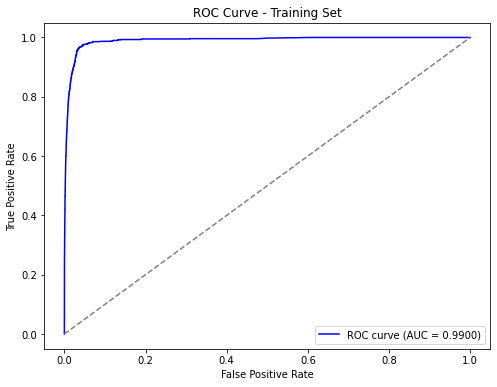

Confusion Matrix for Balanced Training Set:
[[56610  2390]
 [   31   969]]
ROC AUC for Balanced Training Set: 0.9899662796610169
Misclassification for Balanced Training Set: 0.04035


In [18]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_balanced, tpr_train_balanced, color='blue', label='ROC curve (AUC = {:.4f})'.format(roc_auc_train_balanced))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc='lower right')
plt.show();

print("Confusion Matrix for Balanced Training Set:")
print(conf_matrix_train_balanced)
print("ROC AUC for Balanced Training Set:", roc_auc_train_balanced)
print("Misclassification for Balanced Training Set:", misclassification_train_balanced)

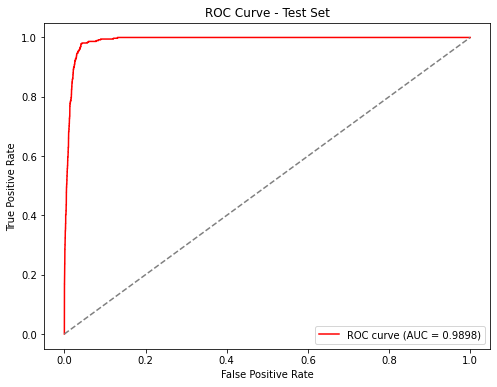

Confusion Matrix Balanced Test Set:
[[15013   612]
 [   12   363]]
ROC AUC for Balanced Test Set: 0.9898238293333335
Misclassification Balanced Test Set: 0.039000000000000035


In [19]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_balanced, tpr_test_balanced, color='red', label='ROC curve (AUC = {:.4f})'.format(roc_auc_test_balanced))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.show();

print("Confusion Matrix Balanced Test Set:")
print( conf_matrix_test_balanced)
print("ROC AUC for Balanced Test Set:", roc_auc_test_balanced)
print("Misclassification Balanced Test Set:", misclassification_test_balanced)

In [20]:
print("Out of Bag (OOB) Error Estimate (Balanced):", oob_error_balanced)

Out of Bag (OOB) Error Estimate (Balanced): 0.04156666666666664


### Using balanced class weight, both test error and OOB error estimate have increased compared to (c). However, in (d), it is the test error that is lower than OOB. 
### (e)
### I will be using 5 fold

In [21]:
X_train, X_test, y_trainn, y_test = train_test_split(x_train_imputed, y_train, test_size=0.2, random_state=42)

pipeline = XGBClassifier(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, use_label_encoder=False)

param_grid = {'alpha': [0.05, 0.07, 0.09, 0.1, 0.13, 0.15, 0.2, 0.5, 0.75, 1, 1.5, 2]}

grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_trainn)

xgb_model = grid_search.best_estimator_
xgb_model.fit(X_train, y_trainn)

y_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_trainn, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

conf_matrix_train = confusion_matrix(y_trainn, xgb_model.predict(X_train))
conf_matrix_test = confusion_matrix(y_test, xgb_model.predict(X_test))

test_error = 1 - xgb_model.score(X_test, y_test)

best_params = grid_search.best_params_['alpha']
print('Best alpha:', best_params)
print('Accuracy:', grid_search.best_score_)

Best alpha: 0.1
Accuracy: 0.9944166666666666


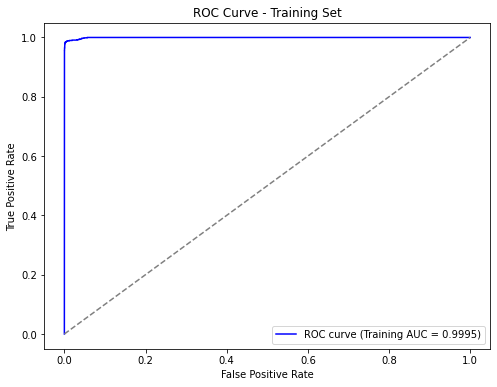

Confusion Matrix Training Set:
[[47207     5]
 [   53   735]]
ROC AUC for Training Set: 0.9995277807285509


In [22]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label='ROC curve (Training AUC = {:.4f})'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc='lower right')
plt.show()

print("Confusion Matrix Training Set:")
print(conf_matrix_train)
print("ROC AUC for Training Set:", roc_auc_train)

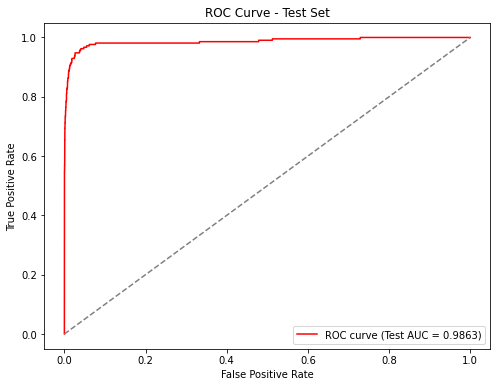

Confusion Matrix Test Set:
[[11769    19]
 [   63   149]]
ROC AUC for Test Set: 0.9863436433597326
Test Error: 0.006833333333333358


In [23]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', label='ROC curve (Test AUC = {:.4f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

print("Confusion Matrix Test Set:")
print(conf_matrix_test)
print("ROC AUC for Test Set:", roc_auc_test)
print("Test Error:", test_error)

### (f)

In [24]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(X_train, y_trainn)

pipeline = XGBClassifier(objective='binary:logistic', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, use_label_encoder=False)

param_grid = {'reg_alpha': [0.05, 0.07, 0.09, 0.1, 0.13, 0.15, 0.2, 0.5, 0.75, 1, 1.5, 2]}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_smote = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
cv_smote.fit(x_train_smote, y_train_smote)

best_params = cv_smote.best_params_['reg_alpha']

estimator_smote = XGBClassifier(objective='binary:logistic', reg_alpha=best_params, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, use_label_encoder=False)

estimator_smote.fit(X_train, y_trainn)

y_train_pred = estimator_smote.predict(X_train)
y_train_pred_prob = estimator_smote.predict_proba(X_train)

y_test_pred = estimator_smote.predict(X_test)
y_test_pred_prob = estimator_smote.predict_proba(X_test)

y_train_pred_proba = y_train_pred_prob[:, 1]
y_test_pred_proba = y_test_pred_prob[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_trainn, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

conf_matrix_train = confusion_matrix(y_trainn, estimator_smote.predict(X_train))
conf_matrix_test = confusion_matrix(y_test, estimator_smote.predict(X_test))

test_error = 1 - estimator_smote.score(X_test, y_test)

print('Best alpha:', best_params)
print('Accuracy:', cv_smote.best_score_)

Best alpha: 0.09
Accuracy: 0.9948953759017123


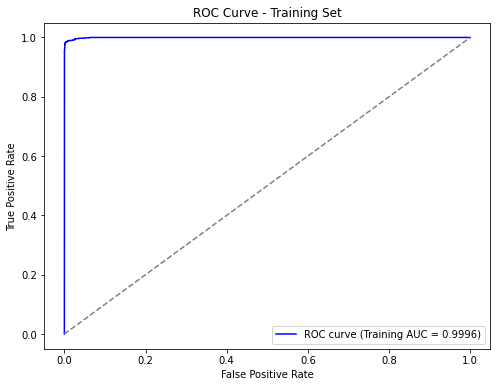

Confusion Matrix Training Set:
[[47205     7]
 [   58   730]]
ROC AUC for Training Set: 0.9995726157550068


In [25]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label='ROC curve (Training AUC = {:.4f})'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc='lower right')
plt.show();

print("Confusion Matrix Training Set:")
print(conf_matrix_train)
print("ROC AUC for Training Set:", roc_auc_train)

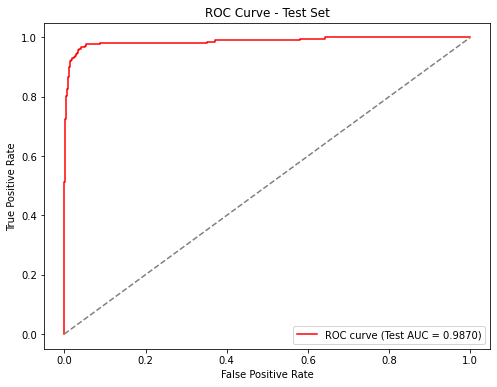

Confusion Matrix Test Set:
[[11768    20]
 [   60   152]]
ROC AUC for Test Set: 0.9869574751426139
Test Error: 0.00666666666666671


In [26]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', label='ROC curve (Test AUC = {:.4f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.show();

print("Confusion Matrix Test Set:")
print(conf_matrix_test)
print("ROC AUC for Test Set:", roc_auc_test)
print("Test Error:", test_error)

### 2.
### (a) iv. As we increment the threshold value, denoted by s, from 0, all coefficients b increase from 0 to their least square estimates. Initially, the training error associated with 0 coefficients is at its peak, gradually diminishing until it converges to the Residual Sum of Squares (RSS) for Ordinary Least Squares.
### (b) ii. As s = 0, all b coefficients are 0, yielding a simple model with high test RSS; with increasing s, b coefficients become non-zero, leading to better fit and decreasing test RSS, until reaching full OLS values, causing overfitting and increasing test RSS.
### (c) iii. At s = 0, the model predicts a constant with minimal variance; as s increases, more b coefficients are included and their values rise, becoming highly dependent on training data and increasing variance.
### (d) iv. At s = 0, the model predicts a constant, resulting in high bias; as s increases, more b coefficients become non-zero, leading to better fitting of the training data and decreasing bias.
### (e) v. Remains constant: Irreducible error, by definition, is model-independent and thus remains constant regardless of the choice of s.
### 3.
### (a) $ (y_1 - \hat{\beta}_1 x_{11} - \hat{\beta}_2 x_{12})^2 + (y_2 - \hat{\beta}_1 x_{21} - \hat{\beta}_2 x_{22})^2 + \lambda(\hat{\beta}_1^2 + \hat{\beta}_2^2)$
### (b) Take derivatives of answer (a) w.r.t both $\hat{\beta}_1$ and $\hat{\beta}_2$ and set them to zero.
### $\hat{\beta}^*_1 = \frac{x_1 y_1 + x_2 y_2 - \hat{\beta}^*_2 (x_{21} + x_{22})}{\lambda + x_{21} + x_{22}}$
### $\hat{\beta}^*_2 = \frac{x_1 y_1 + x_2 y_2 - \hat{\beta}^*_1 (x_{21} + x_{22})}{\lambda + x_{21} + x_{22}}$
### (c) $(y_1 - \hat{\beta}^1 x_{11} - \hat{\beta}^2 x_{12})^2 + (y_2 - \hat{\beta}^1 x_{21} - \hat{\beta}^2 x_{22})^2 + \lambda (|\hat{\beta}^1| + |\hat{\beta}^2|)$
### (d) In this setting, the Lasso coefficients $\hat{\beta}_1$ and $\hat{\beta}_2$ are not unique. Since the L1 regularization term encourages sparsity, there can be multiple solutions where one or both of the coefficients can be zero. Specifically, any solution that satisfies the condition $|\hat{\beta}_1| + |\hat{\beta}_2| \leq \lambda$ is a valid solution. This means there are infinitely many possible solutions lying on the line segment defined by $|\hat{\beta}_1| + |\hat{\beta}_2| = \lambda$. For instance, if $\lambda$ is large enough, both coefficients could be zero, or one could be zero while the other is nonzero, and the exact values of the nonzero coefficients would depend on the specific value of $\lambda$.
### 4.
### Majority voting for classification: Count of P(Class is Red | X) < 0.5 = 4 and P(Class is Red | X) >= 0.5 = 6. So X is classified as red. Average probability: Average probability that P(Class is Red | X) is 4.5/10 = 0.45. Therefore, X is classified as green.
### 5. Is in the notebook folder, separate pdf file named as '5.'

### Reference:

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

https://www.youtube.com/watch?v=zcqTlRgURGA&ab_channel=BillBasener

https://latexeditor.lagrida.com/

https://chat.openai.com/